##Imports

In [3]:
from google.colab import drive
drive.mount('/content/drive')

from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from skimage import metrics
from sklearn.metrics import mean_squared_error, accuracy_score
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from scipy.interpolate import NearestNDInterpolator, CloughTocher2DInterpolator
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys
from tabulate import tabulate
sys.path.append('/content/drive/My Drive/drive_folder')
from custom_dataset_loader import TaiChiDataset, ToTensor
from helper_functions import set_parameter_requires_grad, meshgrid2d, get_grid, plot_learning_curve, split_dataset, initialise_model, get_predictions

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load test dataset

In [5]:
def get_dataloader(dataset, batch_size=16, shuffle=True):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
  return dataloader

TEST_DATA = "synthetic_dataset_test_2023-03-09"
!unzip -d "$TEST_DATA"/ /content/drive/MyDrive/"$TEST_DATA".zip # unziping test data

test_dataset = TaiChiDataset(log_file=TEST_DATA+'/sample_ids.txt',
                              root_dir=TEST_DATA,
                              check=True,
                              transform=transforms.Compose([ToTensor()]))

print(len(test_dataset))
test_dataloader = get_dataloader(test_dataset, shuffle=False)

Archive:  /content/drive/MyDrive/synthetic_dataset_test_2023-03-09.zip
   creating: synthetic_dataset_test_2023-03-09/coords/
  inflating: synthetic_dataset_test_2023-03-09/coords/2165_2.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2273_8.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2299_1.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2412_3.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2317_4.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2226_2.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2244_4.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2314_3.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2437_3.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2160_11.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2387_4.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2206_1.npy  
  inflating: synthetic_dataset_test_2023-03-09/coords/2455_4.npy  
  

## Evaluation helper functions

In [6]:
# load checkpoint
def load_checkpoint(filename):
  try:
    filepath = "/content/drive/MyDrive/checkpoints/"+filename
    
    checkpoint = torch.load(filepath, map_location='cuda:0')
    
    t_history = checkpoint['train_loss_history']
    v_history = checkpoint['val_loss_history']
    train_time = int(checkpoint['train_time'])

    t_losses = np.array([x[1] for x in t_history])
    v_losses = np.array([x[1] for x in v_history])

   
    t_min_arg = np.argmin(t_losses)
    v_min_arg = np.argmin(v_losses)

    print('-' * 50)
    print("Checkpoint data:")
    print("Best train loss: {:.3f} at epoch {}/{}".format(t_history[t_min_arg][1], t_history[t_min_arg][0], len(t_history)))
    print("Best valid loss: {:.3f} at epoch {}/{}".format(v_history[v_min_arg][1], v_history[v_min_arg][0], len(t_history)))
    print("Train time {}h".format(int(train_time)//3600))
    print('-' * 50)

    model_weights = checkpoint['model_weights']
    best_model_weights = checkpoint['best_weights']
    optimizer_state = checkpoint['optimizer']

    return model_weights, best_model_weights, t_history, v_history
  except Exception as e:
    print("ERROR could not load checkpoint:", e)

In [7]:
def run_evaluation(test_dataloader, checkpoint_file=None):
  device = 'cuda'
  running_mse = 0
  running_accuracy = 0
  running_ssim = 0
  running_psnr = 0
  excluded_samples = 0

  running_ssim_GRID = 0
  running_psnr_GRID = 0
  excluded_samples_GRID = 0

  samples = 0

  # initialise model with checkpoint
  # if no checkpoint use baseline (no prediction model)
  if checkpoint_file:
    model = initialise_model(device, to_learn=['all'])
    _, best_model_weights, _, _ = load_checkpoint(checkpoint_file)
    model.load_state_dict(best_model_weights)
    model.eval()
    
  else:
    model = BaselineModel().to(device)
    model.eval()

  # run model at each batch and get predictions 
  for i_batch, sample_batched in enumerate(test_dataloader):
    if i_batch > 20:
      continue
    print("batch {} / {}".format(i_batch, len(test_dataloader)))
    batch_size = len(sample_batched['id'])
    samples += batch_size
    input1 = sample_batched['image0']
    input2 = sample_batched['image3']
    true_images = sample_batched['image7']
    inputs = torch.cat((input1, input2), dim=1)

    # Get ground truth coords and vis
    coords = sample_batched['coords']
    vis = torch.where(sample_batched['vis'] > 0, 1.0, 0.0)

    inputs = inputs.to(device).float() # torch.Size([B, 6, H, W])
    coords = coords.to(device) # torch.Size([B, 1, 4096, 2])
    vis = vis.to(device) # torch.Size([B, 1, 4096])

    with torch.no_grad():
      # Get model outputs 
      outputs = model(inputs) # torch.Size([B, 3, H, W]) same as inputs shape
      outputs = outputs['out'].to(device)
      outputs_coords = outputs[:, :2, :, :]
      outputs_vis = outputs[:, 2, :, :]
      outputs_vis = torch.where(outputs_vis > 0, 1.0, 0.0)

      outputs_coords_grid, outputs_vis_grid = get_predictions(outputs, coords, batch_size)
      outputs_vis_grid = torch.where(outputs_vis_grid > 0, 1.0, 0.0)
      outputs_coords = torch.permute(outputs_coords, (0, 2, 3, 1))
      outputs_vis = outputs_vis.view(batch_size,1,-1)
      outputs_coords = outputs_coords.view(batch_size,1,-1,2) # torch.Size([B, 1, 64*64, 2])

      
      # calculate stats
      running_mse += compute_mse(coords.squeeze().cpu(), outputs_coords_grid.squeeze().cpu())
      running_accuracy += compute_accuracy(vis.squeeze().cpu(), outputs_vis_grid.squeeze().cpu())

      (ssim, psnr, ex) = compute_ssim_psnr(input1, true_images, outputs_coords.cpu().numpy(), outputs_vis.cpu().numpy(), rec_type=["NN","full"]) #pass full output and fist image, last image, type of reconstruction
      running_ssim += ssim
      running_psnr += psnr
      excluded_samples += ex

      (ssim, psnr, ex) = compute_ssim_psnr(input1, true_images, outputs_coords_grid.cpu().numpy(), outputs_vis_grid.cpu().numpy(), rec_type=["NN","grid"]) #pass full output and fist image, last image, type of reconstruction
      running_ssim_GRID += ssim
      running_psnr_GRID += psnr
      excluded_samples_GRID += ex

  psnr = running_psnr/(samples-excluded_samples)
  psnr_GRID = running_psnr_GRID/(samples-excluded_samples_GRID)
  return running_mse/samples, running_accuracy/samples, running_ssim/samples, psnr, running_ssim_GRID/samples, psnr_GRID 

In [8]:
import math
def compute_mse(true_coords, pred_coords):
  batch_score = 0
  batch_size = true_coords.shape[0]

  for i in range(batch_size):
    true_coord = true_coords[i]
    pred_coord = pred_coords[i]
    score = mean_squared_error(true_coord, pred_coord)
    batch_score += score

  return batch_score

def compute_accuracy(true_vis, pred_vis):
  # Compute classification accuracy between ground truth and predicted visibility
  batch_score = 0
  batch_size = true_vis.shape[0]

  for i in range(batch_size):
    true_v = true_vis[i].numpy().flatten().astype(int)
    pred_v = pred_vis[i].numpy().flatten().astype(int)
    score = accuracy_score(true_v, pred_v, normalize=True)
    batch_score += score

  return batch_score

def compute_ssim_psnr(images0, images7, coords, vis, rec_type=["NN","full"]):
  batch_score_ssim = 0
  batch_score_psnr = 0
  batch_size = images0.shape[0]
  ex = 0

  for i in range(batch_size):
    reconstructed_image = frame_reconstruction(images0[i].permute(1, 2, 0).numpy(), coords[i], vis[i], rec_type=rec_type)
    true_image = images7[i].permute(1, 2, 0).numpy()

    psnr = peak_signal_noise_ratio(true_image, reconstructed_image, data_range=255)
    if math.isinf(psnr):
      print('infinity!')
      ex +=1
    else:
      batch_score_psnr += psnr
    batch_score_ssim += structural_similarity(true_image, reconstructed_image, channel_axis=2)

  return batch_score_ssim, batch_score_psnr, ex


### Frame reconstructions

In [9]:
def frame_reconstruction(img0, coords, vis, rec_type=["NN","full"]):
  if rec_type[1]=='full':
    h = np.arange(0, 360) # Take linspace of H of the image
    w = np.arange(0, 640) # Take linspace of W of the image
    w, h = np.meshgrid(w, h)
    original_x = h.flatten()
    original_y = w.flatten()
  else:
    original_points = get_grid(4096, 1, 360, 640)
    original_points = original_points.view(1, 1, -1, 2).squeeze().flatten().cpu().numpy()
    original_x = original_points[1::2]
    original_y = original_points[::2]

  vis = vis.squeeze() > 0
  original_x = original_x[vis]
  original_y = original_y[vis]

  coords = coords.squeeze()
  
  coords_x = coords[:, 1]
  coords_y = coords[:, 0]

  coords_x = coords_x[vis]
  coords_y = coords_y[vis]


  if rec_type[1]=='full':
    coords_x = original_x+coords_x
    coords_y = original_y+coords_y

  if rec_type[0]=="NN":
    reconstructed = interpolate_NN(img0, original_x, original_y, coords_x, coords_y)
  elif rec_type[0]=="CT":
    reconstructed = interpolate_NN(img0, original_x, original_y, coords_x, coords_y) #redo
  elif rec_type[0]=="CT+NN":
    reconstructed = interpolate_NN(img0, original_x, original_y, coords_x, coords_y) #redo

  return reconstructed

In [10]:
def interpolate_NN(img0, original_x, original_y, coords_x, coords_y):
  z = img0
  z_R = []
  z_G = []
  z_B = []

  for point in list(zip(original_x, original_y)):
    x, y = point
    x = int(x)
    y = int(y)
    z_R.append(img0[x, y, 0]) #(360,640,3)
    z_G.append(img0[x, y, 1])
    z_B.append(img0[x, y, 2])
  

  X = np.arange(0, 360) # Take linspace of H of the image
  Y = np.arange(0, 640) # Take linspace of W of the image
  X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

  points = list(zip(coords_x, coords_y))

  interp_R_NN = NearestNDInterpolator(points, z_R) # predicted point coord -> R-intensity
  interp_G_NN = NearestNDInterpolator(points, z_G) # predicted point coord -> G-intensity
  interp_B_NN = NearestNDInterpolator(points, z_B) # predicted point coord -> B-intensity

  Z_R_NN = interp_R_NN(X, Y) 
  Z_G_NN = interp_G_NN(X, Y)
  Z_B_NN = interp_B_NN(X, Y)

  concateneted_NN = np.stack([Z_R_NN, Z_G_NN, Z_B_NN])
  img_NN = concateneted_NN
  reconstruction_NN = img_NN.transpose(2, 1, 0)

  return reconstruction_NN



In [11]:
def interpolate(img0, coords, vis, full=False):
  # Make grid
  if full:
    h = np.arange(0, 360) # Take linspace of H of the image
    w = np.arange(0, 640) # Take linspace of W of the image
    w, h = np.meshgrid(w, h)
    original_x = h.flatten()
    original_y = w.flatten()
  else:
    original_points = get_grid(4096, 1, 360, 640)
    original_points = original_points.view(1, 1, -1, 2).squeeze().flatten().cpu().numpy()
    original_x = original_points[1::2]
    original_y = original_points[::2]

    # sample coords and vis from the grid!!

  original_x = original_x[vis]
  original_y = original_y[vis]

  coords = coords.squeeze()
  
  coords_x = coords[:, 1]
  coords_y = coords[:, 0]

  coords_x = coords_x[vis]
  coords_y = coords_y[vis]


  if full:
    coords_x = original_x+coords_x
    coords_y = original_y+coords_y

  # Take RGB values of tracked points
  # from the input image take RGB values of original grid points
  z = img0
  z_R = []
  z_G = []
  z_B = []

  for point in list(zip(original_x, original_y)):
    x, y = point
    x = int(x)
    y = int(y)
    z_R.append(img0[x, y, 0]) #(360,640,3)
    z_G.append(img0[x, y, 1])
    z_B.append(img0[x, y, 2])
  

  X = np.arange(0, 360) # Take linspace of H of the image
  Y = np.arange(0, 640) # Take linspace of W of the image
  X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation

  points = list(zip(coords_x, coords_y))


  interp_R_NN = NearestNDInterpolator(points, z_R) # predicted point coord -> R-intensity
  interp_G_NN = NearestNDInterpolator(points, z_G) # predicted point coord -> G-intensity
  interp_B_NN = NearestNDInterpolator(points, z_B) # predicted point coord -> B-intensity

  interp_R = CloughTocher2DInterpolator(points, z_R) # predicted point coord -> R-intensity
  interp_G = CloughTocher2DInterpolator(points, z_G) # predicted point coord -> G-intensity
  interp_B = CloughTocher2DInterpolator(points, z_B) # predicted point coord -> B-intensity

  # interpolate the whole 2d grid
  Z_R = interp_R(X, Y) 
  Z_G = interp_G(X, Y)
  Z_B = interp_B(X, Y)

  Z_R_NN = interp_R_NN(X, Y) 
  Z_G_NN = interp_G_NN(X, Y)
  Z_B_NN = interp_B_NN(X, Y)

  concateneted = np.stack([Z_R, Z_G, Z_B])
  concateneted_NN = np.stack([Z_R_NN, Z_G_NN, Z_B_NN])

  img = concateneted
  img_NN = concateneted_NN
  reconstruction_CT = concateneted.transpose(2,1,0)

  # Replace NaN values in img with values in img_NN
  replace_nans = np.where(np.isnan(img), img_NN, img)
  reconstruction = replace_nans
  reconstruction = np.clip(replace_nans, 0, 1)

  reconstruction = reconstruction.transpose(2, 1, 0)
  reconstruction_NN = img_NN.transpose(2, 1, 0)
  return reconstruction, reconstruction_NN, reconstruction_CT

## Baseline evaluation

In [17]:
# create baseline model
# returns no prediction
class BaselineModel(nn.Module):
  def __init__(self):
      super().__init__()
      
  def forward(self, x):
      output_shape = x[:, :3, :, :].size()
      predicted_output = torch.zeros(output_shape)
      predicted_vis = torch.ones((output_shape[0], output_shape[2], output_shape[3]))
      predicted_output[:, 2 ,: , :] = predicted_vis
      return {'out': predicted_output}

In [18]:
baseline_mse, baseline_acc, baseline_ssim, baseline_psnr, baseline_ssim_grid, baseline_psnr_grid = run_evaluation(test_dataloader)

batch 0 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
batch 1 / 54
batch 2 / 54
batch 3 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
infinity!
batch 4 / 54
batch 5 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
batch 6 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
batch 7 / 54
batch 8 / 54
batch 9 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
infinity!
batch 10 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
batch 11 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
infinity!
batch 12 / 54
batch 13 / 54
batch 14 / 54
batch 15 / 54
batch 16 / 54
batch 17 / 54
batch 18 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
batch 19 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
batch 20 / 54


/usr/local/lib/python3.9/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


infinity!
infinity!


In [19]:
from tabulate import tabulate

results = [["Model", "MSE", "Accuracy", "SSIM","PSNR", "SSIM grid","PSNR grid"],
           ["Baseline", baseline_mse, baseline_acc, baseline_ssim, baseline_psnr, baseline_ssim_grid, baseline_psnr_grid]]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═════════╤════════════╤══════════╤═════════╤═════════════╤═════════════╕
│ Model    │     MSE │   Accuracy │     SSIM │    PSNR │   SSIM grid │   PSNR grid │
╞══════════╪═════════╪════════════╪══════════╪═════════╪═════════════╪═════════════╡
│ Baseline │ 1157.83 │   0.942525 │ 0.937029 │ 72.4138 │    0.656312 │     67.4504 │
╘══════════╧═════════╧════════════╧══════════╧═════════╧═════════════╧═════════════╛


## Model without shifting

--------------------------------------------------
Checkpoint data:
Best train loss: 1.743 at epoch 369/371
Best valid loss: 1.843 at epoch 370/371
Train time 17h
--------------------------------------------------


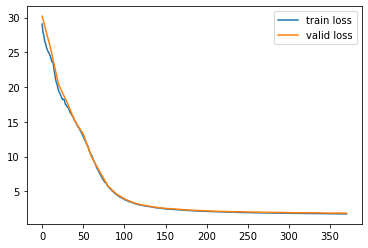

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

--------------------------------------------------
Checkpoint data:
Best train loss: 1.743 at epoch 369/371
Best valid loss: 1.843 at epoch 370/371
Train time 17h
--------------------------------------------------
batch 0 / 54
batch 1 / 54
batch 2 / 54
batch 3 / 54
batch 4 / 54
batch 5 / 54
batch 6 / 54
batch 7 / 54
batch 8 / 54
batch 9 / 54
batch 10 / 54
batch 11 / 54
batch 12 / 54
batch 13 / 54
batch 14 / 54
batch 15 / 54
batch 16 / 54
batch 17 / 54
batch 18 / 54
batch 19 / 54
batch 20 / 54


In [12]:
# load model and evaluate
_, _, t_history, v_history=load_checkpoint("synthetic_model_1_checkpoint_2023-03-15_0517.pth")
plot_learning_curve(t_history, v_history)
m1_mse, m1_acc, m1_ssim, m1_psnr, m1_ssim_grid, m1_psnr_grid = run_evaluation(test_dataloader, checkpoint_file="synthetic_model_1_checkpoint_2023-03-15_0517.pth")

In [13]:
from tabulate import tabulate

results = [["Model", "MSE", "Accuracy", "SSIM","PSNR", "SSIM grid","PSNR grid"],
           ["No Shifting", m1_mse, m1_acc, m1_ssim, m1_psnr, m1_ssim_grid, m1_psnr_grid]]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤═════════╤════════════╤══════════╤═════════╤═════════════╤═════════════╕
│ Model       │     MSE │   Accuracy │     SSIM │    PSNR │   SSIM grid │   PSNR grid │
╞═════════════╪═════════╪════════════╪══════════╪═════════╪═════════════╪═════════════╡
│ No Shifting │ 509.838 │    0.99473 │ 0.446675 │ 63.2772 │    0.657006 │     68.5975 │
╘═════════════╧═════════╧════════════╧══════════╧═════════╧═════════════╧═════════════╛


## Model with shifting

--------------------------------------------------
Checkpoint data:
Best train loss: 3.005 at epoch 336/342
Best valid loss: 2.679 at epoch 341/342
Train time 19h
--------------------------------------------------


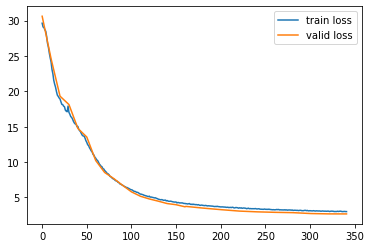

--------------------------------------------------
Checkpoint data:
Best train loss: 3.005 at epoch 336/342
Best valid loss: 2.679 at epoch 341/342
Train time 19h
--------------------------------------------------
batch 0 / 54
batch 1 / 54
batch 2 / 54
batch 3 / 54
batch 4 / 54
batch 5 / 54
batch 6 / 54
batch 7 / 54
batch 8 / 54
batch 9 / 54
batch 10 / 54
batch 11 / 54
batch 12 / 54
batch 13 / 54
batch 14 / 54
batch 15 / 54
batch 16 / 54
batch 17 / 54
batch 18 / 54
batch 19 / 54
batch 20 / 54


In [14]:
# load model and evaluate
_, _, t_history, v_history = load_checkpoint("synthetic_model_2_shift_checkpoint_2023-03-15_0708.pth")
plot_learning_curve(t_history, v_history)
m2_mse, m2_acc, m2_ssim, m2_psnr, m2_ssim_grid, m2_psnr_grid = run_evaluation(test_dataloader, checkpoint_file="synthetic_model_2_shift_checkpoint_2023-03-15_0708.pth")

In [15]:
results = [["Model", "MSE", "Accuracy", "SSIM","PSNR", "SSIM grid","PSNR grid"],
           ["With Shifting", m2_mse, m2_acc, m2_ssim, m2_psnr,  m2_ssim_grid, m2_psnr_grid]]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤═════════╤════════════╤══════════╤═════════╤═════════════╤═════════════╕
│ Model         │     MSE │   Accuracy │     SSIM │    PSNR │   SSIM grid │   PSNR grid │
╞═══════════════╪═════════╪════════════╪══════════╪═════════╪═════════════╪═════════════╡
│ With Shifting │ 506.039 │   0.989027 │ 0.433689 │ 63.2299 │    0.652308 │     68.4086 │
╘═══════════════╧═════════╧════════════╧══════════╧═════════╧═════════════╧═════════════╛


## Results on half of the test set

In [20]:
results = [["Model", "MSE", "Accuracy", "SSIM (NN, full)","PSNR (NN, full)", "SSIM (NN, grid)","PSNR (NN, grid)"],
           ["Baseline", baseline_mse, baseline_acc, baseline_ssim, baseline_psnr, baseline_ssim_grid, baseline_psnr_grid],
           ["No Shifting", m1_mse, m1_acc, m1_ssim, m1_psnr, m1_ssim_grid, m1_psnr_grid],
           ["With Shifting", m2_mse, m2_acc, m2_ssim, m2_psnr, m2_ssim_grid, m2_psnr_grid]]

print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════╤══════════╤════════════╤═══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╕
│ Model         │      MSE │   Accuracy │   SSIM (NN, full) │   PSNR (NN, full) │   SSIM (NN, grid) │   PSNR (NN, grid) │
╞═══════════════╪══════════╪════════════╪═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ Baseline      │ 1157.83  │   0.942525 │          0.937029 │           72.4138 │          0.656312 │           67.4504 │
├───────────────┼──────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ No Shifting   │  509.838 │   0.99473  │          0.446675 │           63.2772 │          0.657006 │           68.5975 │
├───────────────┼──────────┼────────────┼───────────────────┼───────────────────┼───────────────────┼───────────────────┤
│ With Shifting │  506.039 │   0.989027 │          0.433689 │           63.2299 │          0.652308 │           68.4086 │
╘═══════════════╧═══════